In [97]:
# Essential libraries
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,utils
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
!unzip '/content/UTKFace'

In [99]:
dataset_folder_name = '/content/UTKFace'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [100]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']


    df = df.dropna()

    return df

In [101]:
df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and
# visualize data by plotting graphs.

,age,gender,race,file
0,25.0,male,white,/content/UTKFace/25_0_0_20170117151643003.jpg....
1,22.0,male,white,/content/UTKFace/22_0_0_20170103234830581.jpg....
2,32.0,male,asian,/content/UTKFace/32_0_2_20170116165412041.jpg....
3,24.0,male,white,/content/UTKFace/24_0_0_20170113210126343.jpg....
4,28.0,female,white,/content/UTKFace/28_1_0_20170104181556245.jpg....


In [102]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16382 entries, 0 to 16382
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     16382 non-null  float64
 1   gender  16382 non-null  object 
 2   race    16382 non-null  object 
 3   file    16382 non-null  object 
dtypes: float64(1), object(3)
memory usage: 639.9+ KB


In [103]:
df.describe()

# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,16382.000000
mean,25.189598
std,11.398341
min,1.000000
25%,22.000000
50%,26.000000
75%,32.000000
max,116.000000


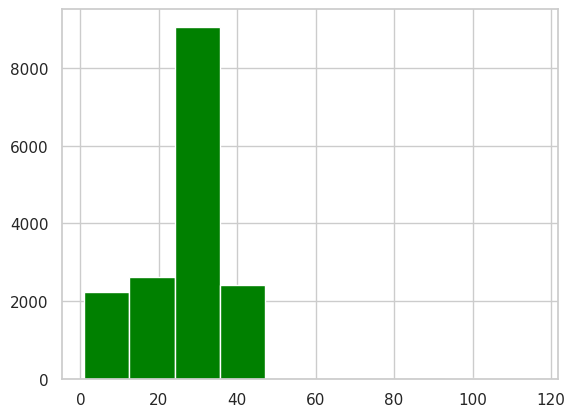

In [104]:
#plot Age Distribution
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Majority population lies between 20-30 age group. Clearly, the dataset is not very well balanced. So training will
# not be easy & accurate. We don't want to be biased. Try using class weights ?


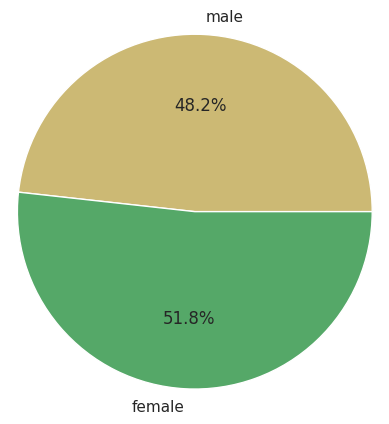

In [105]:
#plot Gender Distribution
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g']
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

<Axes: xlabel='gender', ylabel='count'>

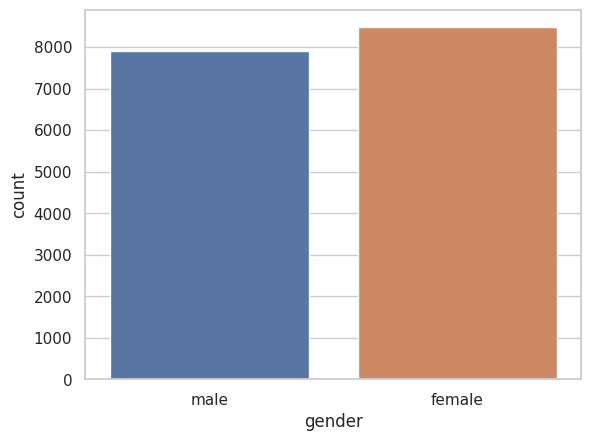

In [106]:
sns.countplot(x='gender', data=df)
# Males ~ Just over 12k
# Females ~ Just over 11k

In [107]:
df.groupby(['gender']).mean()

<ipython-input-107-d6e5c832dfad>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['gender']).mean()


,age
gender,
female,24.543053
male,25.883097


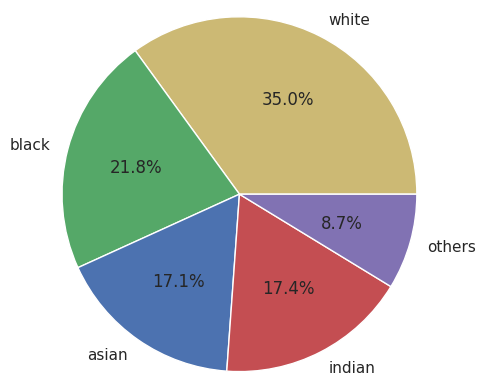

In [108]:
#plot Race Distribution
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m']
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

<Axes: xlabel='race', ylabel='count'>

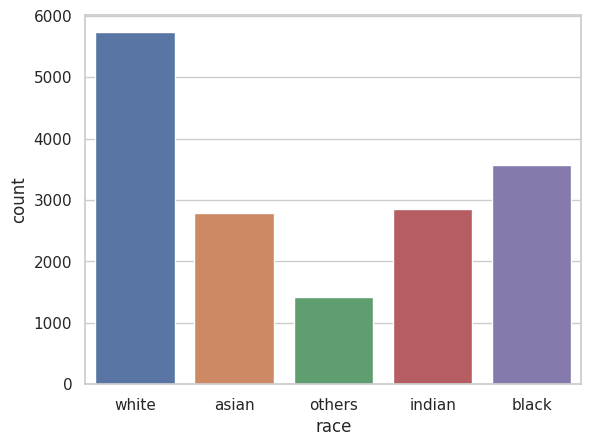

In [109]:
sns.countplot(x='race', data=df)

In [110]:
df.groupby(['race']).mean()

<ipython-input-110-2b8230ecf84e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['race']).mean()


,age
race,
asian,21.044707
black,28.615234
indian,25.004205
others,21.803221
white,26.013082


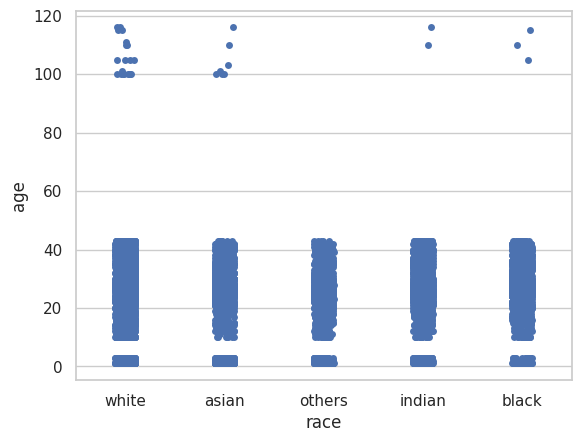

In [111]:
sns.set(style ="whitegrid")
_ = sns.stripplot(x='race',y='age',data=df)

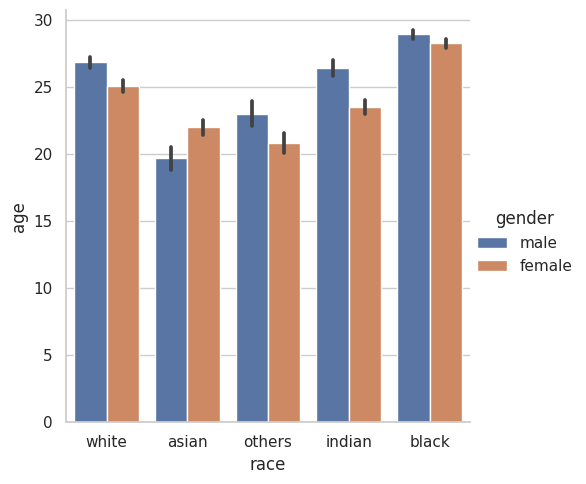

In [112]:
sns.catplot(x='race', y='age', hue='gender', data=df, kind='bar')

# Gives the mean age of both genders of all races

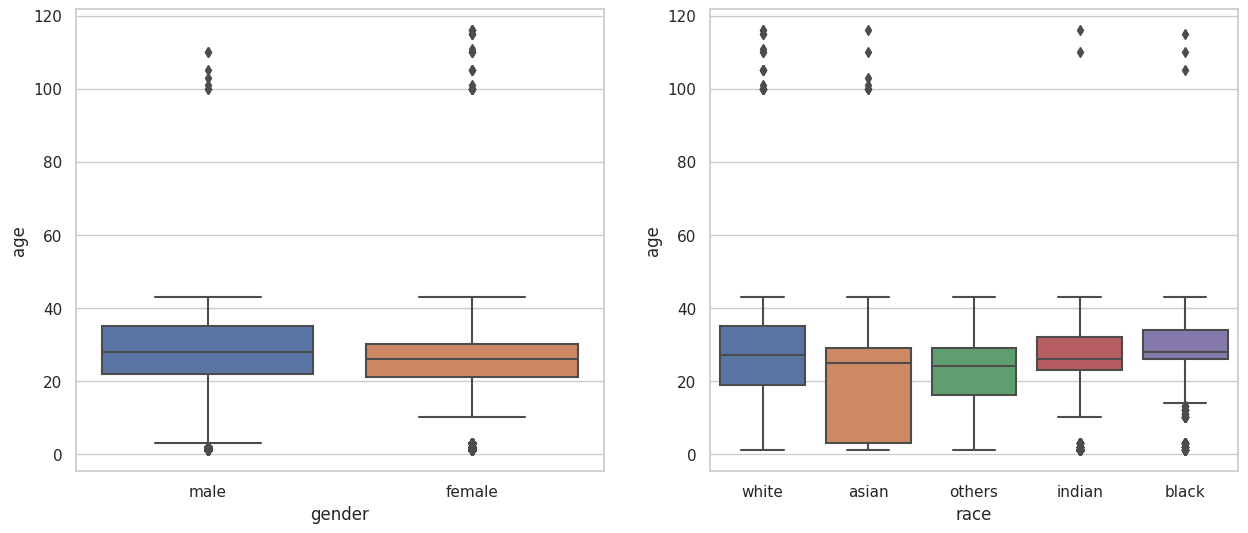

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

In [114]:
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups -
0. 0-24
1. 25-49
2. 50-74
3. 75-99
4. 100-124 '''

' This basically makes 5 divisions in age-groups - \n0. 0-24\n1. 25-49\n2. 50-74\n3. 75-99\n4. 100-124 '

In [115]:
df['age'].value_counts()

1.0    10615
0.0     5735
4.0       32
Name: age, dtype: int64

In [116]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c)

5735   10615   0   0   32   0


In [117]:
df.head()

,age,gender,race,file
0,1.0,male,white,/content/UTKFace/25_0_0_20170117151643003.jpg....
1,0.0,male,white,/content/UTKFace/22_0_0_20170103234830581.jpg....
2,1.0,male,asian,/content/UTKFace/32_0_2_20170116165412041.jpg....
3,0.0,male,white,/content/UTKFace/24_0_0_20170113210126343.jpg....
4,1.0,female,white,/content/UTKFace/28_1_0_20170104181556245.jpg....


In [177]:
from keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx

def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.

    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0

    return im

def generate_images(image_idx, is_training, batch_size=16):  # Used to generate a batch with images when training/validating our model.

    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]

            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']

            im = preprocess_image(file)

            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)

            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []

        if not is_training:
            break

In [170]:
len(dataset_dict['race_alias'])

5

In [178]:
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import SpatialDropout2D
from keras.layers import Lambda
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

def build_gender_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_race_branch(inputs):
    x = make_default_hidden_layers(inputs)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(len(dataset_dict['race_alias']))(x)
    x = Activation("softmax", name="race_output")(x)
    return x

def build_age_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)

    return x

def assemble_model(width, height):
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)
    race_branch = build_race_branch(inputs)

    model = Model(inputs=inputs, outputs=[age_branch, race_branch, gender_branch], name="face_net")

    return model


model = assemble_model(198, 198)

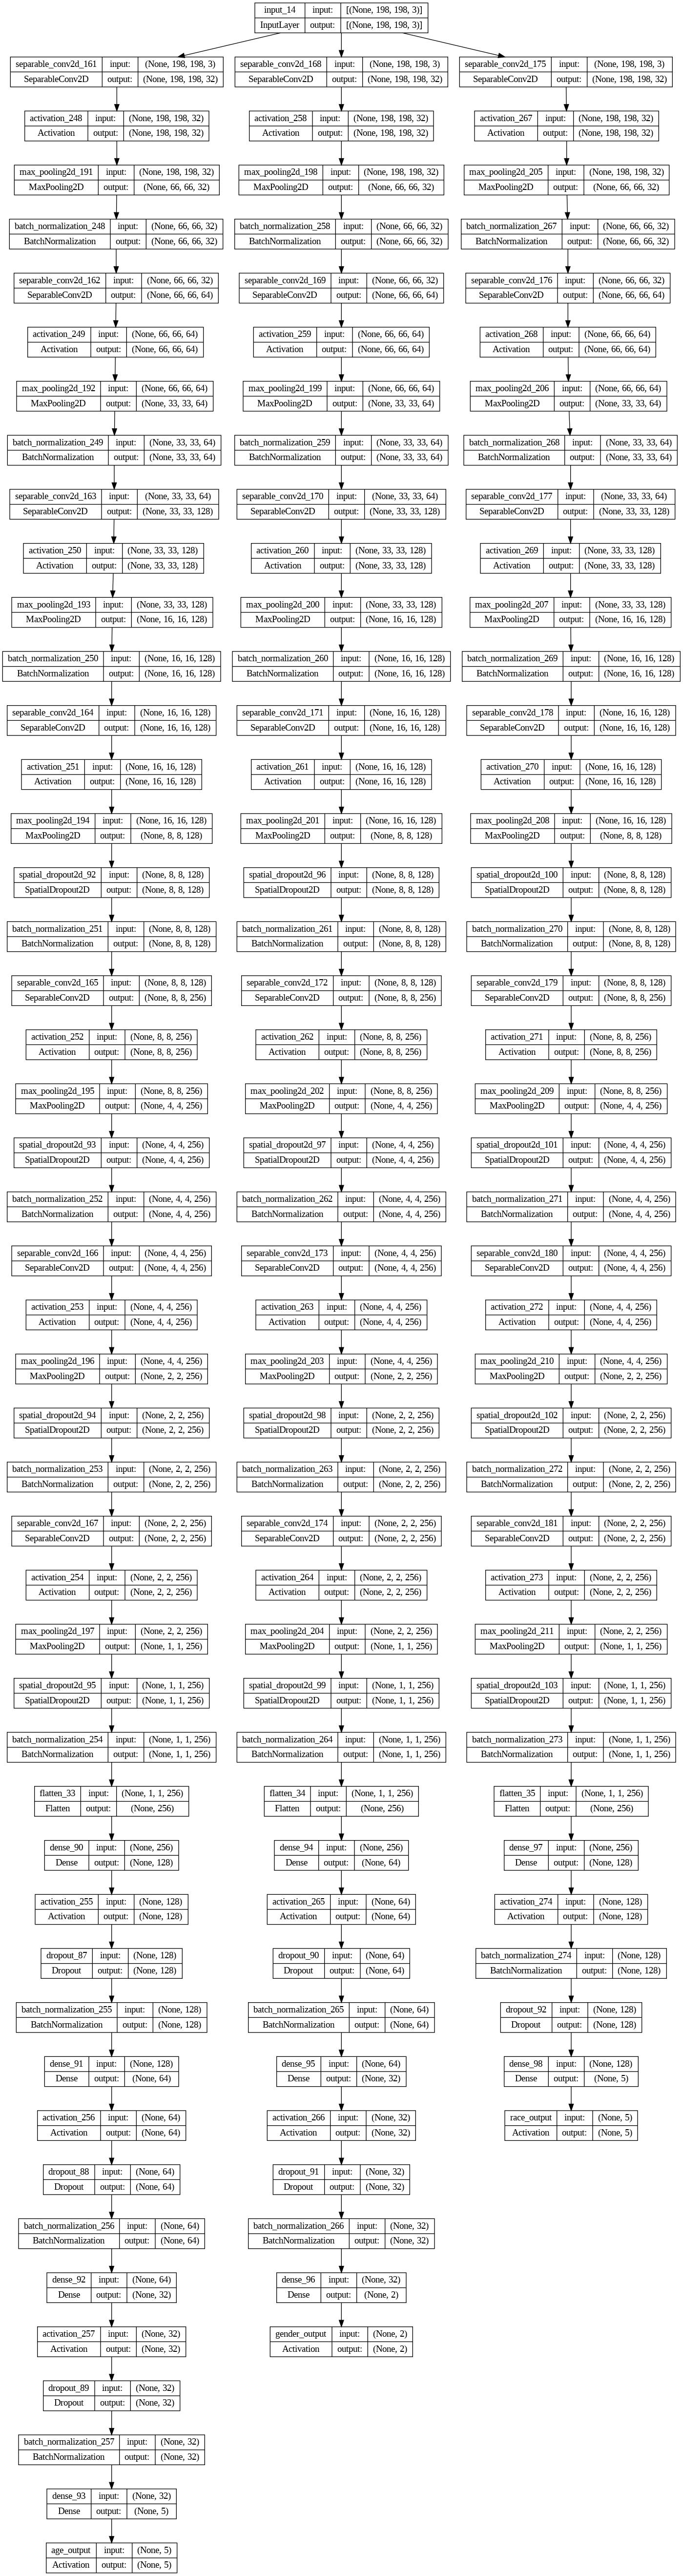

In [173]:
tf.keras.utils.plot_model(model, to_file='Demographic_model.png', show_shapes=True)

In [39]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_14 (Separable  (None, 198, 198, 32  155        ['input_2[0][0]']                
 Conv2D)                        )                                                                 
                                                                                                  
 activation_19 (Activation)     (None, 198, 198, 32  0           ['separable_conv2d_14[0][0]']    
                                )                                                          

In [179]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

#  When training a neural network, the learning rate is often the most important
# hyperparameter to tune. When training deep neural networks, it is often useful
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

opt = Adam()
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt,
              loss={
                  'age_output': 'categorical_crossentropy',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'accuracy',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

In [180]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique([0,1,4]),
                                        y = np.array(df['age'])
                                    )
class_weight1 = {'age_output': class_weight}

In [181]:
batch_size = 32
valid_batch_size = 32

train_gen = generate_images(train_idx, is_training=True, batch_size=batch_size)

# Since, train_idx is too large to fit inside RAM at once, we generate batches of size 32/64 from it (called train_gen))

valid_gen = generate_images(val_idx, is_training=True, batch_size=batch_size)


history = model.fit(train_gen,steps_per_epoch = len(train_idx)//batch_size, epochs=22  ,callbacks=callbacks_list,validation_data=valid_gen,validation_steps=len(val_idx)//batch_size)

Epoch 1/22
409/409 [==============================] - 142s 276ms/step - loss: 3.2814 - age_output_loss: 0.7216 - race_output_loss: 1.5227 - gender_output_loss: 0.5760 - age_output_accuracy: 0.6436 - race_output_accuracy: 0.4053 - gender_output_accuracy: 0.7016 - val_loss: 3.1925 - val_age_output_loss: 0.6328 - val_race_output_loss: 1.7176 - val_gender_output_loss: 0.6853 - val_age_output_accuracy: 0.6752 - val_race_output_accuracy: 0.3545 - val_gender_output_accuracy: 0.7381 - lr: 0.0080
Epoch 2/22
409/409 [==============================] - 81s 197ms/step - loss: 2.3062 - age_output_loss: 0.5889 - race_output_loss: 1.1862 - gender_output_loss: 0.3742 - age_output_accuracy: 0.7216 - race_output_accuracy: 0.5520 - gender_output_accuracy: 0.8254 - val_loss: 2.5947 - val_age_output_loss: 0.5862 - val_race_output_loss: 1.2845 - val_gender_output_loss: 0.5539 - val_age_output_accuracy: 0.7368 - val_race_output_accuracy: 0.5794 - val_gender_output_accuracy: 0.8073 - lr: 0.0080
Epoch 3/22
409/

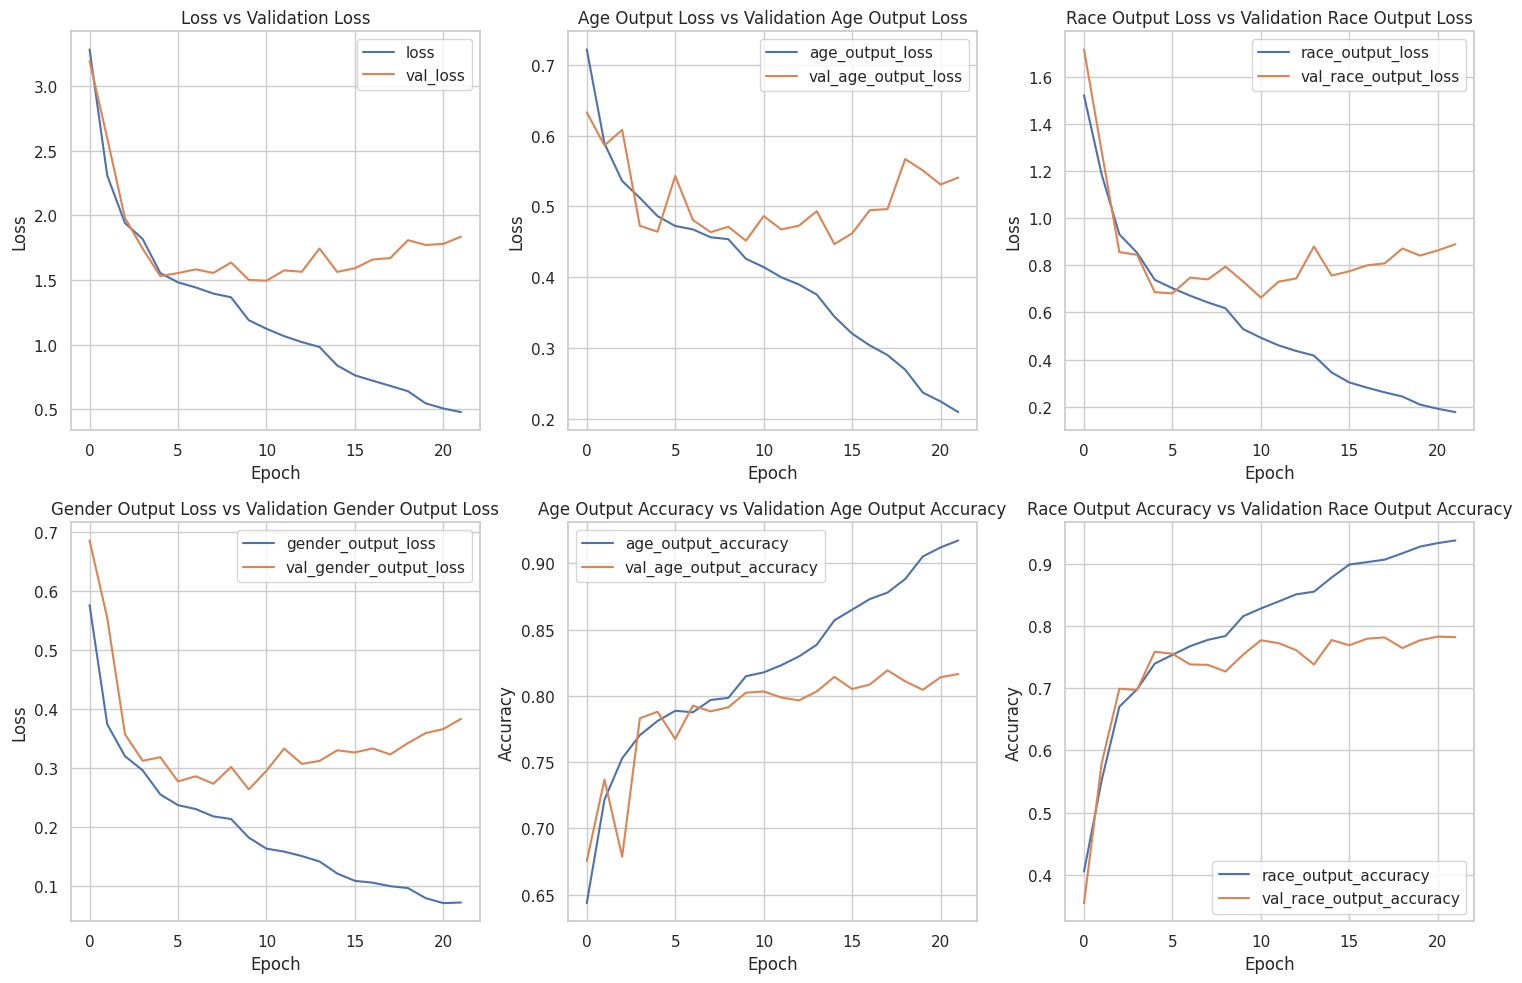

In [198]:
# Create a figure with 2x3 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loss plot
axs[0, 0].plot(history.history['loss'], label='loss')
axs[0, 0].plot(history.history['val_loss'], label='val_loss')
axs[0, 0].set_title('Loss vs Validation Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Age Output Loss plot
axs[0, 1].plot(history.history['age_output_loss'], label='age_output_loss')
axs[0, 1].plot(history.history['val_age_output_loss'], label='val_age_output_loss')
axs[0, 1].set_title('Age Output Loss vs Validation Age Output Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Race Output Loss plot
axs[0, 2].plot(history.history['race_output_loss'], label='race_output_loss')
axs[0, 2].plot(history.history['val_race_output_loss'], label='val_race_output_loss')
axs[0, 2].set_title('Race Output Loss vs Validation Race Output Loss')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].legend()

# Gender Output Loss plot
axs[1, 0].plot(history.history['gender_output_loss'], label='gender_output_loss')
axs[1, 0].plot(history.history['val_gender_output_loss'], label='val_gender_output_loss')
axs[1, 0].set_title('Gender Output Loss vs Validation Gender Output Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Age Output Accuracy plot
axs[1, 1].plot(history.history['age_output_accuracy'], label='age_output_accuracy')
axs[1, 1].plot(history.history['val_age_output_accuracy'], label='val_age_output_accuracy')
axs[1, 1].set_title('Age Output Accuracy vs Validation Age Output Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

# Race Output Accuracy plot
axs[1, 2].plot(history.history['race_output_accuracy'], label='race_output_accuracy')
axs[1, 2].plot(history.history['val_race_output_accuracy'], label='val_race_output_accuracy')
axs[1, 2].set_title('Race Output Accuracy vs Validation Race Output Accuracy')
axs[1, 2].set_xlabel('Epoch')
axs[1, 2].set_ylabel('Accuracy')
axs[1, 2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [185]:
model.save('/content/a_g_r_best.h5')         # Saving the above run model. It has performed best till date.

In [186]:
from keras.models import load_model
model = load_model('/content/a_g_r_best.h5')

In [192]:
def loadImage(filepath):
  test_img = load_img(filepath, target_size=(198, 198))
  test_img = img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

In [199]:
def max_race_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

1/1 [==============================] - 0s 25ms/step


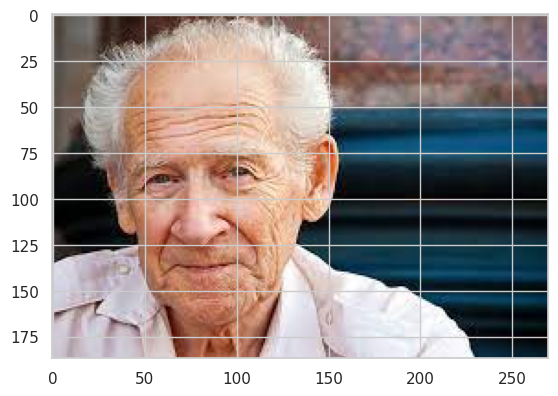

0-24 yrs old
Male
white


In [205]:
picture = "/content/old_man.jfif"
age_pred,race_pred ,gender_pred = model.predict(loadImage(picture))
img = load_img(picture)
plt.imshow(img)
plt.show()
max=-1
count=0

for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')
print(dataset_dict['race_id'][np.argmax(race_pred)])